In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch import optim
from tqdm import tqdm, trange, tqdm_notebook
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import model_selection as ms
from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
batch_size = 128
train_data = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
dataset = fetch_openml('mnist_784')
x = np.array(dataset['data'])
y = np.array(dataset['target'], dtype='int32')
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.25, random_state=1)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, input):
        input = F.relu(self.l1(input))
        return F.log_softmax(self.l2(input), dim=1)

In [6]:
EPOCHS = 5
net = Net()
opt = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    i = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        opt.zero_grad()
        output = net(x)
        #  https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835
        loss = F.nll_loss(output, y)
        loss.backward()
        opt.step()
    print(loss)

tensor(0.2252, grad_fn=<NllLossBackward>)
tensor(0.1525, grad_fn=<NllLossBackward>)
tensor(0.1673, grad_fn=<NllLossBackward>)
tensor(0.1955, grad_fn=<NllLossBackward>)
tensor(0.1415, grad_fn=<NllLossBackward>)


In [7]:
print(output.shape)

torch.Size([128, 10])


In [8]:
layer = net.l1.state_dict()
print(layer['weight'])
print(layer['bias'].shape)

tensor([[ 0.0055, -0.0285,  0.0140,  ..., -0.0224, -0.0220, -0.0153],
        [ 0.0335,  0.0091, -0.0168,  ...,  0.0226, -0.0031,  0.0258],
        [-0.0187,  0.0267,  0.0113,  ..., -0.0327,  0.0049,  0.0016],
        ...,
        [ 0.0319,  0.0154,  0.0252,  ..., -0.0142, -0.0225,  0.0025],
        [ 0.0216,  0.0025,  0.0302,  ...,  0.0315,  0.0242, -0.0322],
        [-0.0101, -0.0173,  0.0127,  ..., -0.0054,  0.0077, -0.0310]])
torch.Size([128])


In [9]:
total = 0
correct = 0

with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        correct += int(torch.sum(y == torch.argmax(output, axis = 1)))
        total += batch_size

print(f"Accuracy: {correct/total * 100}%")

Accuracy: 97.56288109756098%


In [10]:
outputs = []
with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        outputs.extend(list(torch.max(output, 1)[0]))
outputs = np.array(outputs)

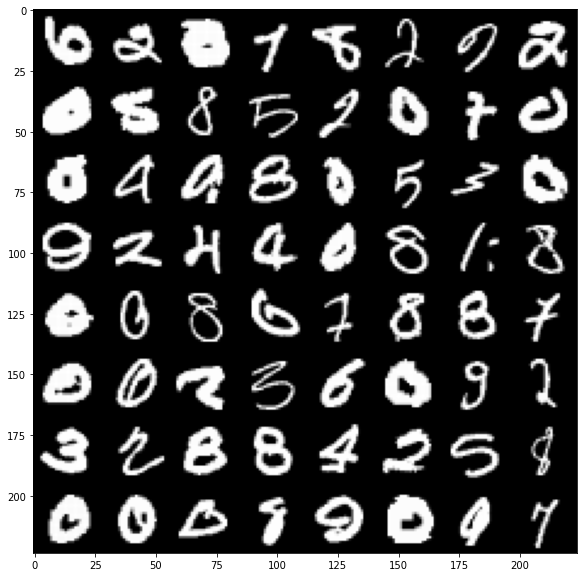

In [11]:
sorted_list = sorted(list(zip(outputs, range(outputs.shape[0]))))
x_bad = x_train[[x[1] for x in sorted_list[:64]]].reshape(8, 28*8, 28)

# let's take a look at the most weird image
plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate(x_bad, axis=1), cmap='gray')

In [12]:
# Useful links
# https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
# https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
# https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss
# https://stats.stackexchange.com/questions/223256/does-the-cross-entropy-cost-make-sense-in-the-context-of-regression#:~:text=In%20general%2C%20you%20can%20define,to%20a%20squared%20Mahalanobis%20distance.&text=So%20yes%2C%20cross%2Dentropy%20can%20be%20used%20for%20regression.

In [71]:
np.random.seed(1337)
def init_layer(x, y):
    # TODO: use a better way for initializing weights
    # return np.random.rand(x, y)
    return np.random.uniform(-1., 1., size=(x,y))/np.sqrt(x*y)

def relu(input):
    return np.maximum(input, 0)

def log_softmax(x):
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    # https://stackoverflow.com/questions/61567597/how-is-log-softmax-implemented-to-compute-its-value-and-gradient-with-better
    # return (input - np.log(np.sum(np.exp(input), axis=1)))
    c = x.max(axis=1)
    return x - (c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))).reshape((-1, 1))

learning_rate = 0.001

In [82]:
def forward_backward(x, y):
    """
    Some dimensional analysis:
    x = input image of shape: batch_size * 784
    y = true output for the images of shape: batch_size * 10
    l1 = weights of layer 1 w shape: 784 * 128
    l2 = weights of layer 2 w shape: 128 * 10
    
    x_l1 = the dot product of x and l1 of shape: batch_size * 128
    x_relu = the ReLU activation function applied on x_l1 of shape: batch_size * 128
    x_l2 = the dot product of x_relu and l2 of shape: batch_size * 10
    y_pred = the log-softmax function applied on x_l2 of shape: batch_size * 10
    
    d_l2 = derivative of nll_loss * derivative of lsm * x_relu of shape: 128 * 10
    d_l1 = derivative of y_pred wrt x_relu * derivative of x_relu * x of shape: 784 * 128
    """
    y_mod = np.zeros((len(y), 10))
    y_mod[range(len(y)), y] = 1
    
    x_l1 = x.dot(l1)
    x_relu = relu(x_l1)
    x_l2 = x_relu.dot(l2)
    # y_pred = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    y_pred = log_softmax(x_l2)
    loss = (-y_mod * y_pred).mean(axis=1)
    
    # derivative of loss wrt y_pred
    d_ypred = -(y_mod / y_mod.shape[0])
    # derivative of log-softmax
    d_lsm = d_ypred - (np.exp(y_pred) * d_ypred.sum(axis=1).reshape((-1, 1)))
    # derivative of layer 2 weights
    d_l2 = x_relu.T.dot(d_lsm)
    
    # derivative of x_l2 wrt to loss
    d_relu = d_lsm.dot(l2.T)
    # derivative of relu
    d_xl1 = (x_relu > 0).astype('float32') * d_relu
    # derivative of layer 1 weights
    d_l1 = x.T.dot(d_xl1)
    
#     print(y_mod.shape)
#     print(x_l1.shape)
#     print(x_l2.shape)
#     print(y_pred.shape)
#     print(loss.shape)
#     print(d_ypred.shape)
#     print(d_lsm.shape)
#     print(d_l2.shape)
#     print(d_relu.shape)
#     print(d_xl1.shape)
#     print(d_l1.shape)
    
    return y_pred, d_l1, d_l2, loss

# samp = [0,1,2,3]
# y_pred, d_l1, d_l2, loss = forward_backward(x_test[samp].reshape((-1, 28*28)), y_test[samp])

# plt.imshow(d_l1.T)
# plt.figure()
# plt.imshow(d_l2.T)

In [ ]:
EPOCHS = 10
batch_size = 128
learning_rate = 0.001

l1 = init_layer(28*28, 128)
l2 = init_layer(128, 10)

losses = []
accuracies = []

for epoch in trange(EPOCHS):
    for i in range(1000):
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        x = x_train[idx]
        y = y_train[idx]
        y_pred, d_l1, d_l2, loss = forward_backward(x, y)
        l1 -= learning_rate * d_l1
        l2 -= learning_rate * d_l2
        losses.append(loss.mean())
        correct = int(np.sum(y == np.argmax(y_pred, axis = 1)))
        accuracies.append(correct/batch_size)
    print(y)
    print(np.argmax(y_pred, axis=1))
    print(correct)
    print(correct/batch_size)
    print(loss.mean())

 10%|█         | 1/10 [00:10<01:30, 10.06s/it]

[7 9 0 8 4 2 4 0 8 4 8 8 2 9 8 2 9 8 7 9 4 4 1 3 8 8 4 4 9 2 4 8 3 8 0 5 7
 7 8 1 9 6 6 9 4 3 3 1 6 1 1 8 6 7 1 1 1 4 4 1 6 7 9 2 3 0 3 8 0 1 4 1 6 1
 1 3 9 2 4 1 2 3 1 5 1 3 8 3 2 2 8 5 7 2 6 4 5 1 3 8 9 3 5 1 6 9 9 1 7 5 1
 9 5 4 4 0 3 2 0 5 1 0 1 3 0 4 8 6]
[7 9 0 8 9 2 4 0 8 4 8 8 2 9 8 2 9 8 7 9 4 4 7 3 8 8 4 4 9 2 4 8 3 8 0 5 7
 7 8 1 9 6 6 9 4 3 3 1 6 1 1 8 6 7 1 1 1 4 4 1 6 7 9 2 3 0 3 8 0 1 4 1 6 1
 1 3 9 2 4 1 2 3 1 5 1 3 8 3 2 2 8 5 7 2 6 4 5 1 3 8 9 3 3 1 6 9 9 1 7 5 1
 9 5 4 4 0 3 2 0 5 1 0 1 3 0 4 8 6]
125
0.9765625
0.010716797308095171


 20%|██        | 2/10 [00:20<01:20, 10.05s/it]

[6 1 7 4 0 1 2 0 1 1 4 3 3 4 7 8 7 5 2 5 6 4 8 4 0 7 4 8 9 2 9 1 1 3 6 2 0
 5 4 8 7 2 9 1 8 5 8 7 7 1 5 3 5 5 4 2 5 4 1 8 0 1 2 4 2 5 2 2 0 6 8 3 4 3
 1 6 4 3 4 7 0 1 5 8 4 7 2 4 9 1 2 0 5 4 7 5 7 2 4 9 4 7 0 0 9 3 2 2 7 8 2
 7 3 4 5 0 9 9 5 0 4 4 4 8 7 2 1 9]
[6 1 7 4 0 1 2 0 1 1 4 3 3 4 7 8 7 5 2 5 6 4 8 4 0 7 4 8 9 2 9 1 1 3 6 2 0
 5 4 8 7 2 9 1 8 5 8 7 7 1 5 3 5 5 4 2 5 4 1 8 0 1 2 4 2 5 2 2 0 6 8 3 4 3
 1 6 4 7 4 7 0 1 5 8 7 7 2 4 9 1 2 0 5 4 7 5 7 2 4 9 4 7 0 0 9 3 2 2 7 8 2
 7 3 4 5 0 9 9 5 0 4 4 4 8 7 2 1 9]
126
0.984375
0.00846589885544291


 30%|███       | 3/10 [00:28<01:05,  9.40s/it]

[4 8 5 2 5 7 6 6 4 9 8 0 1 8 3 9 4 6 0 9 8 9 0 7 6 6 0 5 3 5 2 9 5 3 0 5 9
 4 8 4 0 1 3 8 6 9 5 2 9 4 6 6 8 0 7 1 3 3 1 1 2 0 4 4 7 5 3 8 2 2 6 4 8 9
 3 5 9 7 0 7 3 4 3 5 2 5 3 0 3 3 5 2 4 3 1 7 7 5 1 1 5 3 1 2 9 1 2 0 2 1 6
 3 6 0 3 5 3 9 4 7 0 9 3 1 4 0 3 9]
[4 8 5 2 5 7 6 6 4 9 8 0 1 8 3 9 4 6 0 9 8 9 0 7 6 6 0 5 3 5 2 9 5 3 0 5 9
 4 8 4 0 1 3 8 6 9 5 2 9 4 6 6 8 0 7 1 3 3 1 1 2 0 4 4 7 5 3 8 2 2 6 4 8 9
 3 5 9 7 0 7 3 4 3 5 2 5 3 0 3 3 5 2 4 3 1 7 7 5 1 1 5 3 1 2 9 1 2 0 2 1 6
 3 6 0 3 5 3 9 4 7 0 9 3 1 4 0 3 9]
128
1.0
0.0014437662097933064


 40%|████      | 4/10 [00:37<00:54,  9.05s/it]

[8 5 6 0 1 2 9 4 2 7 9 0 7 1 0 1 3 0 6 5 6 4 2 9 4 1 9 2 6 8 5 7 4 4 7 9 7
 9 1 6 2 1 1 9 4 8 5 0 3 0 1 8 7 0 5 4 3 8 9 2 0 5 3 1 9 1 6 6 7 2 6 3 9 5
 1 2 7 8 3 0 8 5 7 5 0 1 8 9 0 5 5 5 2 9 6 7 4 9 0 0 7 5 1 4 0 8 6 2 0 9 2
 2 6 3 5 5 0 6 4 8 2 0 7 0 1 6 4 5]
[8 5 6 0 1 2 9 4 2 7 9 0 7 1 0 1 3 0 6 5 6 4 2 9 4 1 9 2 6 8 5 7 4 4 7 9 7
 9 1 6 2 1 1 9 4 8 5 0 3 0 1 8 7 0 5 4 3 8 9 2 0 5 3 1 9 1 6 6 7 2 6 3 9 5
 1 2 7 8 3 0 8 5 7 5 0 1 8 9 0 5 5 5 2 9 6 7 4 9 0 0 7 5 1 4 0 8 6 2 0 9 2
 2 6 3 5 5 0 6 4 8 2 0 7 0 1 6 4 8]
127
0.9921875
0.004805501468074066


 50%|█████     | 5/10 [00:46<00:45,  9.16s/it]

[4 3 1 9 6 9 7 0 3 7 1 1 0 0 9 0 0 8 3 7 3 8 5 9 1 9 1 5 9 3 2 9 7 9 7 3 2
 3 2 2 8 4 3 9 8 6 0 9 5 2 5 6 7 2 8 2 4 8 0 9 3 7 0 5 0 4 0 7 0 3 1 2 0 8
 7 6 6 5 9 4 4 8 3 1 4 2 2 8 3 2 2 6 0 4 6 9 9 5 7 9 4 7 9 9 6 4 9 4 8 4 4
 5 3 9 8 7 1 2 9 3 1 4 1 7 7 1 9 5]
[4 3 1 9 6 9 7 0 3 7 1 1 0 0 9 0 0 8 3 7 3 8 5 9 1 9 1 5 9 3 2 9 7 9 7 3 1
 3 2 2 8 4 3 9 8 6 0 9 5 2 5 6 7 2 8 2 4 8 0 9 3 7 0 5 0 4 0 7 0 3 1 2 0 8
 7 6 6 5 9 4 4 8 3 1 4 2 2 8 3 2 2 6 0 4 6 9 9 5 7 9 4 7 9 9 6 4 9 4 8 4 4
 5 3 9 8 7 1 2 9 3 1 4 1 7 7 1 9 5]
127
0.9921875
0.0021656983867902914


 60%|██████    | 6/10 [00:57<00:39,  9.77s/it]

[9 6 4 1 0 4 1 3 7 0 8 8 2 3 0 5 0 5 0 8 1 1 0 3 8 8 6 4 3 7 3 7 3 3 3 8 8
 6 1 4 6 8 6 1 1 0 5 7 6 5 3 7 6 7 4 0 4 6 1 2 4 3 9 0 6 5 8 5 8 9 3 1 1 9
 7 3 5 6 9 6 5 0 0 8 7 3 2 5 0 4 1 8 4 5 3 6 9 1 2 2 6 7 8 4 9 9 1 8 5 7 1
 5 9 4 4 6 6 1 9 3 6 3 0 1 4 7 0 4]
[9 6 4 1 0 4 1 3 7 0 8 8 2 3 0 5 0 5 0 8 1 1 0 3 8 8 6 4 3 7 3 7 3 3 3 8 8
 6 1 4 6 8 6 1 1 0 5 7 6 5 3 7 6 7 4 0 4 6 1 2 4 3 9 0 6 5 8 5 8 9 3 1 1 9
 7 3 5 6 9 6 5 0 0 8 7 3 2 5 0 4 1 8 4 5 3 6 9 1 2 2 6 7 8 4 9 9 1 8 5 7 1
 5 9 4 4 6 6 1 9 3 6 3 0 1 4 7 0 4]
128
1.0
0.002077968878753082


 70%|███████   | 7/10 [01:09<00:31, 10.55s/it]

[7 0 9 9 5 5 5 2 4 3 1 6 6 5 4 8 1 2 0 6 3 0 4 7 1 9 8 5 4 2 6 5 1 3 3 9 1
 0 0 1 5 2 6 5 0 7 9 6 5 8 8 9 0 6 2 3 7 4 8 4 0 0 2 1 0 9 8 1 2 0 2 9 3 2
 3 0 9 2 6 2 2 7 4 1 2 4 9 3 2 6 3 6 7 1 4 9 2 4 2 9 1 8 4 4 3 3 4 3 7 8 8
 5 3 5 2 4 5 6 4 0 1 6 6 0 2 9 6 9]
[7 0 9 9 5 5 5 2 4 3 1 6 6 5 4 8 1 2 0 6 3 0 4 7 1 9 8 5 4 2 6 5 1 3 3 9 1
 0 0 1 5 2 6 5 0 7 9 6 5 8 8 9 0 6 2 3 7 4 8 4 0 0 2 1 0 9 8 1 2 0 2 9 3 2
 3 0 9 2 6 2 2 7 4 1 2 4 9 3 2 6 3 6 7 1 4 9 2 4 2 9 1 8 4 4 3 3 4 3 7 8 8
 5 3 5 2 4 5 6 4 0 1 6 6 0 2 9 6 9]
128
1.0
0.0010945220784958618


 80%|████████  | 8/10 [01:20<00:21, 10.50s/it]

[3 3 4 9 1 3 4 9 5 6 0 0 0 7 0 3 2 1 9 1 2 0 3 4 5 2 0 2 3 4 5 4 0 1 5 6 4
 1 6 4 8 9 2 3 5 0 4 8 8 4 7 8 2 8 8 0 8 2 1 1 6 8 6 0 9 7 0 7 2 9 7 9 9 3
 6 3 0 7 0 5 9 3 1 7 3 7 9 5 7 1 0 2 1 9 2 2 7 3 4 0 2 4 8 5 1 0 1 2 9 6 5
 0 8 3 9 5 3 9 3 2 2 3 7 2 6 3 0 3]
[3 3 4 9 1 3 4 9 5 6 0 0 0 7 0 3 2 1 9 1 2 0 3 4 5 2 0 2 3 4 5 4 0 1 5 6 4
 1 6 4 8 9 2 3 5 0 4 8 8 4 7 8 2 8 8 0 8 2 1 1 6 8 6 0 9 7 0 7 2 9 7 9 9 3
 6 3 0 7 0 5 9 3 1 7 3 7 9 5 7 1 0 2 1 9 2 2 7 3 4 0 2 4 8 5 1 0 1 2 9 6 5
 0 8 3 9 5 3 9 3 2 2 3 7 2 6 3 0 3]
128
1.0
0.001085970499540588
